<a href="https://colab.research.google.com/github/foydalideveloper/Vehicle-Detection/blob/main/HighPerformance_Vehicle_and_License_Plate_Detector_using_custom_YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

# Importing Libraries


In [3]:
import os
import yaml
import cv2
import random
from glob import glob
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import os
import yaml
import cv2
import random
import shutil
from glob import glob
from ultralytics import YOLO
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Step 1: Unzip Dataset

In [8]:
import zipfile

zip_path = 'uzbek_lplate.zip'


extract_dir = 'uzbek_license_final_v3'

# --- Unzipping Logic ---
print(f"Starting to unzip '{zip_path}'...")

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
    print(f"Created directory: '{extract_dir}'")
else:
    print(f"Directory '{extract_dir}' already exists. Files will be extracted into it.")

# Unzipping the file into the target directory
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f" Successfully extracted '{zip_path}' to the '{extract_dir}' directory.")
except FileNotFoundError:
    print(f" ERROR: The file '{zip_path}' was not found. Please check the filename and make sure it's in the correct location.")
except Exception as e:
    print(f" An error occurred: {e}")

Starting to unzip 'uzbek_lplate.zip'...
Created directory: 'uzbek_license_final_v3'
 Successfully extracted 'uzbek_lplate.zip' to the 'uzbek_license_final_v3' directory.


# Step 2: Analyze and Verify the Data

In [9]:

from collections import Counter


DATASET_DIR = "uzbek_license_final_v3"

# --- Analysis and Preparation Logic ---

def analyze_and_prepare_dataset(dataset_dir):
    """
    Analyzes the YOLO dataset by counting class distributions and creates
    a clean, reliable YAML file with absolute paths for training.
    """
    print(f"\n--- Starting Step 2: Analyzing Dataset in '{dataset_dir}' ---")

    # --- Reading the Original data.yaml to get class names ---
    original_yaml_path = os.path.join(dataset_dir, 'data.yaml')
    original_names = []
    if os.path.exists(original_yaml_path):
        with open(original_yaml_path, 'r') as f:
            original_data = yaml.safe_load(f)
            original_names = original_data.get('names', [])
            print(f"Read original 'data.yaml'. Found {len(original_names)} classes: {original_names}")
    else:
        print(" Warning: Original 'data.yaml' not found. Cannot verify class names.")
        return # Stop if we can't find the config file

    # --- Auditing Label Files ---
    print("\nAuditing label files...")
    class_counts = Counter()

    # Precising search for .txt files inside 'labels' subdirectories
    label_search_pattern = os.path.join(dataset_dir, '**/labels/*.txt')
    label_files = glob(label_search_pattern, recursive=True)

    if not label_files:
        print(" Error: No label files found. Please check your dataset structure.")
        return

    for label_file in label_files:
        try:
            with open(label_file, 'r') as f:
                for line in f:
                    if line.strip():
                        # YOLO format is: class_id x_center y_center width height
                        parts = line.strip().split()
                        if len(parts) == 5: # Bounding box must have 5 values
                            class_id = int(parts[0])
                            class_counts[class_id] += 1
                        else:
                            # This helps catch any remaining segmentation data
                            print(f" Warning: Skipping malformed line (not 5 parts) in {os.path.basename(label_file)}")
        except (IndexError, ValueError) as e:
            print(f" Warning: Skipping malformed line in {os.path.basename(label_file)}. Error: {e}")

    # --- Displaying the Audit Report ---
    print("\n--- Dataset Audit Report ---")
    if not class_counts:
        print("No labels found in the dataset.")
        return

    print("Class Distribution Found:")
    for class_id, count in sorted(class_counts.items()):
        if 0 <= class_id < len(original_names):
            class_name = original_names[class_id]
        else:
            class_name = 'Unknown Class'

        print(f"  - Class ID {class_id} ('{class_name}'): {count} instances")

    total_labels = sum(class_counts.values())
    print(f"Total Labels Found: {total_labels}")
    print("----------------------------\n")

    # --- Creating the Final data.yaml for Training ---
    print("Creating a standardized 'data_cleaned.yaml' for training...")

    corrected_data_yaml_content = {
        'train': os.path.abspath(os.path.join(dataset_dir, 'train/images')),
        'val': os.path.abspath(os.path.join(dataset_dir, 'valid/images')),
        'test': os.path.abspath(os.path.join(dataset_dir, 'test/images')),
        'nc': len(original_names),
        'names': original_names
    }

    corrected_yaml_path = os.path.join(dataset_dir, 'data_cleaned.yaml')
    with open(corrected_yaml_path, 'w') as f:
        yaml.dump(corrected_data_yaml_content, f, sort_keys=False, default_flow_style=False)

    print(f" Successfully created corrected YAML file at: {corrected_yaml_path}")
    print("This file contains absolute paths and is ready for training.")
    print(f"Final class mapping: {dict(enumerate(original_names))}")

analyze_and_prepare_dataset(DATASET_DIR)


--- Starting Step 2: Analyzing Dataset in 'uzbek_license_final_v3' ---
Read original 'data.yaml'. Found 2 classes: ['car', 'license_plate']

Auditing label files...

--- Dataset Audit Report ---
Class Distribution Found:
  - Class ID 0 ('car'): 229 instances
  - Class ID 1 ('license_plate'): 229 instances
Total Labels Found: 458
----------------------------

Creating a standardized 'data_cleaned.yaml' for training...
 Successfully created corrected YAML file at: uzbek_license_final_v3/data_cleaned.yaml
This file contains absolute paths and is ready for training.
Final class mapping: {0: 'car', 1: 'license_plate'}


# Step 3: Visualize the Annotations

--- Starting Step 3: Visualizing 2 random samples from the 'train' set ---

--- Showing Sample 1/2 ---
Displaying Image: '11788265-copy_jpg.rf.7f043b3f9f17b2100d97ff8198bbce6a.jpg' | Original Dimensions: 640x640


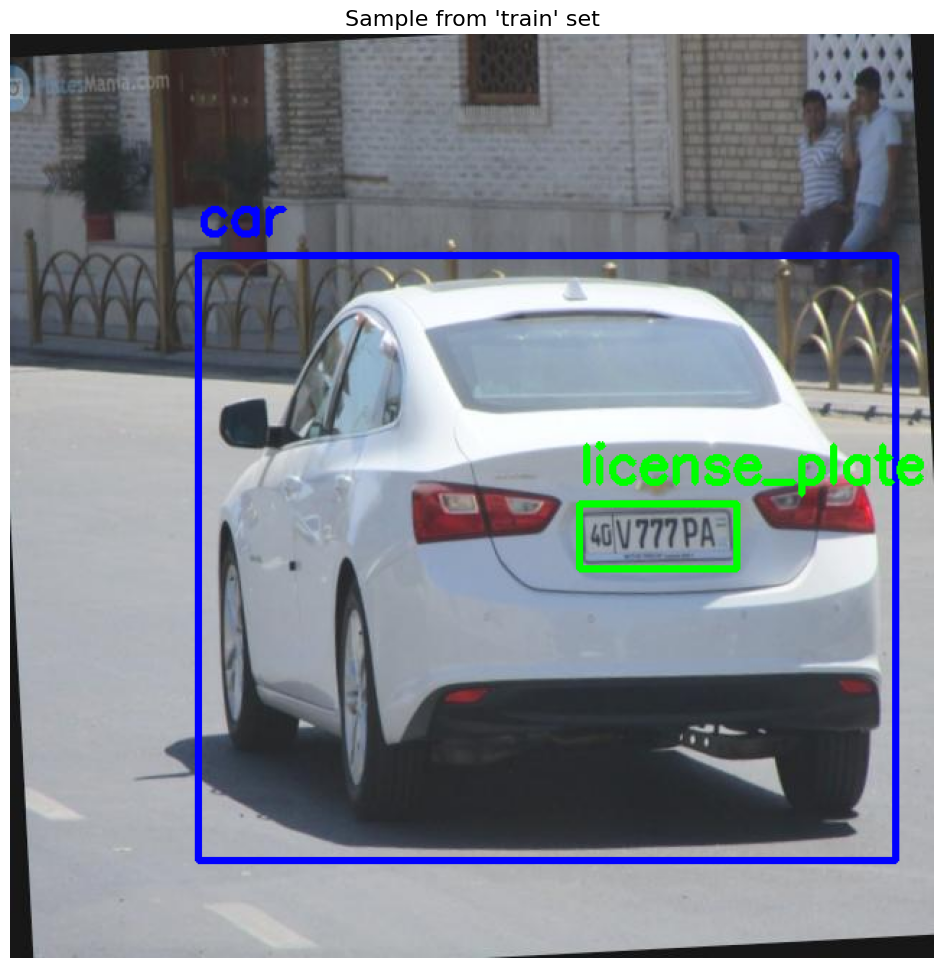


--- Showing Sample 2/2 ---
Displaying Image: 'image-18-copy_webp.rf.372b8958a301e79e43ef54a9e91b5b29.jpg' | Original Dimensions: 640x640


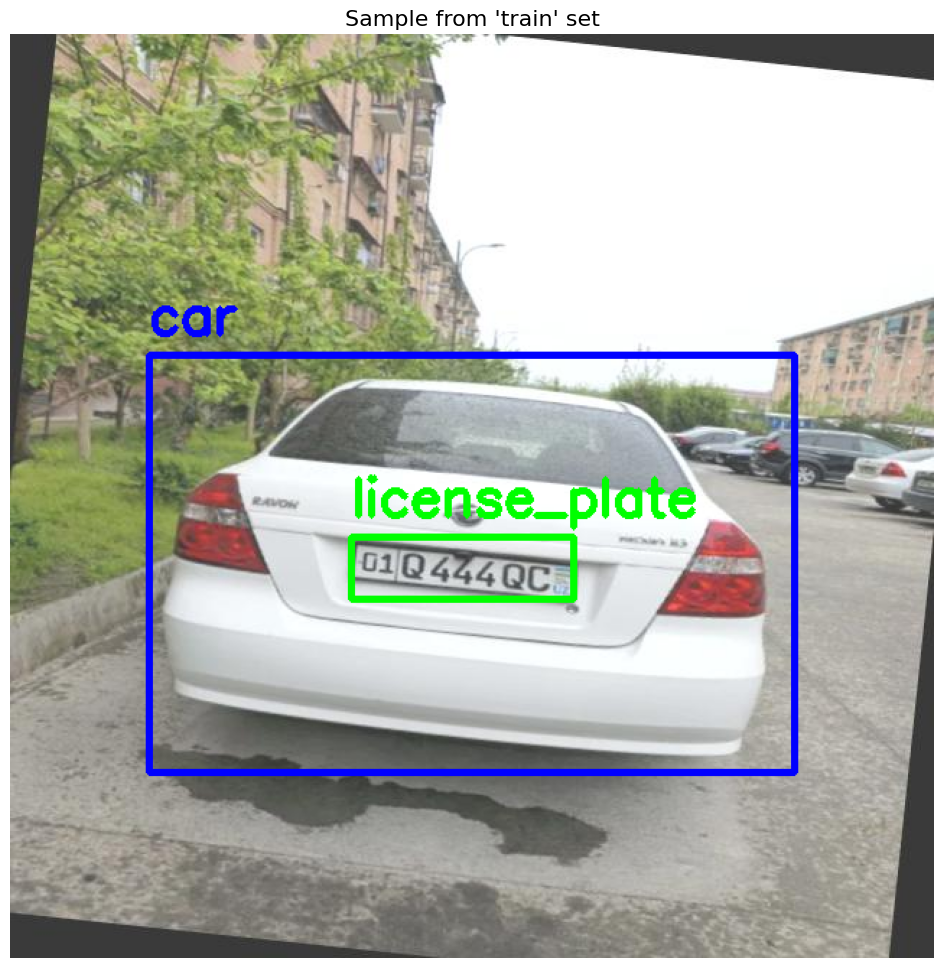

In [11]:

DATASET_DIR = "uzbek_license_final_v3"
NUM_SAMPLES_TO_SHOW = 2

# --- Visualization Logic (the function remains the same) ---
def visualize_sample(dataset_dir, split='train'):
    """
    Displaying a random image from a specified split with its bounding boxes
    to visually verify the annotations are correct.
    """

    yaml_path = os.path.join(dataset_dir, 'data_cleaned.yaml')
    if not os.path.exists(yaml_path):
        print(f" Error: 'data_cleaned.yaml' not found. Please run Step 2 first.")
        return

    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
        class_names = data['names']
        image_dir = data[split]

    label_dir = os.path.join(os.path.dirname(image_dir), 'labels')

    if not os.path.exists(image_dir) or not os.listdir(image_dir):
        print(f" Error: No images found in '{image_dir}'. Check your YAML file paths.")
        return

    # Getting a list of all images and pick one randomly
    all_images = os.listdir(image_dir)
    random_image_name = random.choice(all_images)
    image_path = os.path.join(image_dir, random_image_name)
    label_path = os.path.join(label_dir, os.path.splitext(random_image_name)[0] + '.txt')

    image = cv2.imread(image_path)
    if image is None:
        print(f" Error: Could not load image at {image_path}")
        return
    h, w, _ = image.shape
    print(f"Displaying Image: '{random_image_name}' | Original Dimensions: {w}x{h}")

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:5])

                    box_w, box_h = int(width * w), int(height * h)
                    x1, y1 = int((x_center * w) - (box_w / 2)), int((y_center * h) - (box_h / 2))

                    color = (0, 255, 0) if class_id == 1 else (255, 0, 0)

                    cv2.rectangle(image, (x1, y1), (x1 + box_w, y1 + box_h), color, 3)
                    label = class_names[class_id]
                    cv2.putText(image, label, (x1, y1 - 15), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 12))
    plt.imshow(image_rgb)
    plt.title(f"Sample from '{split}' set", fontsize=16)
    plt.axis('off')
    plt.show()

# --- Runing the visualization in a loop to show 5 samples ---
print(f"--- Starting Step 3: Visualizing {NUM_SAMPLES_TO_SHOW} random samples from the 'train' set ---")
for i in range(NUM_SAMPLES_TO_SHOW):
    print(f"\n--- Showing Sample {i+1}/{NUM_SAMPLES_TO_SHOW} ---")
    visualize_sample(DATASET_DIR, split='train')

# Step 4: Train the YOLOv8 Model

In [12]:

from ultralytics import YOLO

DATASET_DIR = "uzbek_license_final_v3"

# --- Starting Training ---
print("\n--- Starting Step 4: Training the YOLOv8 Model ---")
print("This may take a while depending on your hardware...")

# 'yolov8s.pt' is slightly larger and more accurate.
model = YOLO('yolov8s.pt')

# Defining the path to our clean and verified YAML file.
data_yaml_path = os.path.join(DATASET_DIR, 'data_cleaned.yaml')

# Training the model on our dataset.
results = model.train(
    data=data_yaml_path,                       # Path to our dataset configuration file
    epochs=100,                                # Number of times to train on the whole dataset
    imgsz=640,                                 # Standard image size for training
    patience=20,                               # Stop if no improvement after 20 epochs
    batch=16,                                  # Number of images to process at once (reduce if you get memory errors)
    name='uzbek_plates_yolov8s_v3_final'       # A clear name for this final training run
)

print("\n--- Training Complete! ---")
print("Find results, weights, and graphs in the 'runs/detect/uzbek_plates_yolov8s_v3_final' folder.")
print("\nThe best model weights are saved as 'best.pt' inside that folder.")


--- Starting Step 4: Training the YOLOv8 Model ---
This may take a while depending on your hardware...


100%|██████████| 21.5M/21.5M [00:00<00:00, 313MB/s]


Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=uzbek_license_final_v3/data_cleaned.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=uzbek_plates_yolov8s_v3_final, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.

100%|██████████| 755k/755k [00:00<00:00, 35.1MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

 22        [15, 18, 21]  1   2116822  ultralytics.nn.modules.head.Detect           [2, [128, 256, 512]]          
Model summary: 129 layers, 11,136,374 parameters, 11,136,358 gradients, 28.6 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 161MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1220.1±464.8 MB/s, size: 58.0 KB)


train: Scanning /content/uzbek_license_final_v3/train/labels... 201 images, 0 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:00<00:00, 2486.16it/s]

train: New cache created: /content/uzbek_license_final_v3/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 737.9±523.3 MB/s, size: 59.0 KB)


val: Scanning /content/uzbek_license_final_v3/valid/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 1683.68it/s]

val: New cache created: /content/uzbek_license_final_v3/valid/labels.cache


Plotting labels to runs/detect/uzbek_plates_yolov8s_v3_final/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/uzbek_plates_yolov8s_v3_final
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.54G      1.211      2.469      1.529         36        640: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all         19         38      0.838       0.79      0.934      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.78G      1.017      1.062        1.3         27        640: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         19         38      0.921       0.83      0.953      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.81G      1.004     0.9184      1.306         36        640: 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         19         38      0.795      0.842      0.867      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.85G      1.037     0.9246      1.304         36        640: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         19         38      0.759      0.803      0.855      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.88G      1.032     0.8827      1.314         34        640: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         19         38      0.831      0.896      0.924      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.92G      1.045     0.8222      1.324         38        640: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         19         38      0.703      0.739      0.675      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.96G      1.031     0.8347      1.332         38        640: 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         19         38      0.775      0.584      0.689      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.99G      1.049     0.8429      1.328         38        640: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         19         38      0.656      0.605      0.666      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.03G      1.064     0.7759      1.318         44        640: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         19         38      0.506      0.526      0.509       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.07G      1.027     0.7581      1.303         29        640: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         19         38      0.693      0.553       0.57      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       4.1G     0.9632     0.7077      1.271         34        640: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         19         38       0.62      0.579      0.585      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.14G     0.9383      0.681      1.246         40        640: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         19         38      0.725      0.737      0.787      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.17G     0.9806     0.6875      1.273         42        640: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         19         38      0.818      0.895      0.899       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.21G     0.9737     0.7094      1.269         44        640: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         19         38      0.913      0.846      0.932      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.25G     0.9256     0.6833      1.243         36        640: 100%|██████████| 13/13 [00:03<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         19         38      0.751      0.842      0.757      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.35G     0.9571      0.696      1.258         39        640: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         19         38      0.716      0.974      0.765      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.39G      0.936     0.6677      1.249         35        640: 100%|██████████| 13/13 [00:04<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         19         38      0.674      0.977      0.698       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.49G     0.9512     0.6625      1.234         30        640: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         19         38      0.772      0.974      0.819      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.53G     0.9517     0.6668      1.283         43        640: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         19         38      0.872      0.947      0.932      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       4.6G     0.8909     0.6221       1.24         40        640: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         19         38      0.981      0.816      0.931      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.66G     0.8675     0.6041      1.217         28        640: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         19         38      0.957      0.931      0.967      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.74G      0.868       0.59      1.193         28        640: 100%|██████████| 13/13 [00:03<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         19         38      0.953      0.974      0.988      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.77G     0.9018     0.5963      1.228         41        640: 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         19         38      0.973      0.947      0.977      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.84G      0.896     0.6047      1.229         40        640: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         19         38       0.97      0.969      0.988      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.91G     0.8397     0.5848      1.194         34        640: 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         19         38      0.976      0.921      0.967      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.01G     0.8115     0.5629      1.163         36        640: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         19         38      0.948      0.895      0.925       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.05G     0.8382     0.5889      1.212         36        640: 100%|██████████| 13/13 [00:03<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         19         38      0.996      0.929      0.973      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.12G     0.8272     0.5695      1.175         34        640: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         19         38       0.94      0.947      0.962      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.15G      0.773     0.5692      1.155         30        640: 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         19         38      0.954      0.918      0.975      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.26G     0.8015     0.5777      1.191         36        640: 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         19         38      0.994      0.971       0.99       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       5.3G     0.7721     0.5559      1.154         35        640: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         19         38      0.977      0.974      0.984      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.37G     0.7578     0.5328      1.139         40        640: 100%|██████████| 13/13 [00:03<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


                   all         19         38      0.985      0.945      0.975      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.43G     0.7665     0.5327      1.131         37        640: 100%|██████████| 13/13 [00:04<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         19         38      0.951      0.959      0.975      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.51G     0.7355     0.5059      1.112         44        640: 100%|██████████| 13/13 [00:03<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         19         38      0.975      0.959      0.974      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.57G     0.7682     0.5048      1.134         34        640: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         19         38      0.956      0.945      0.979      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.64G     0.7522     0.5225      1.149         34        640: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         19         38       0.97      0.971      0.987      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.68G     0.7772     0.5024      1.144         44        640: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         19         38       0.98      0.959      0.974      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.78G     0.7823     0.5095      1.145         28        640: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         19         38      0.997      0.973      0.992      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.82G     0.8099     0.5169       1.15         37        640: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all         19         38      0.944      0.905      0.977      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.89G     0.7427     0.5126      1.136         36        640: 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         19         38      0.971       0.92      0.969      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.96G     0.7016     0.4752      1.111         35        640: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         19         38      0.979      0.971      0.985      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.03G     0.7308     0.4963      1.127         37        640: 100%|██████████| 13/13 [00:04<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         19         38       0.99      0.973      0.991      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       6.1G     0.6817     0.4568      1.104         27        640: 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         19         38      0.995      0.945      0.991      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.13G     0.6898     0.4674      1.097         47        640: 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         19         38      0.994      0.947      0.985      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       6.2G     0.6594     0.4499      1.082         38        640: 100%|██████████| 13/13 [00:03<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         19         38      0.946      0.921      0.965      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.27G     0.6664     0.4607      1.069         31        640: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         19         38       0.97      0.947       0.95      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.34G     0.6932     0.4853      1.116         31        640: 100%|██████████| 13/13 [00:04<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         19         38      0.959      0.944      0.957      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.41G     0.6701     0.4564      1.078         37        640: 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         19         38      0.997      0.974      0.979      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.48G      0.639     0.4413      1.071         42        640: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         19         38      0.984      0.974      0.992      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.55G     0.6364     0.4249      1.066         48        640: 100%|██████████| 13/13 [00:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         19         38      0.977      0.985      0.995      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.62G      0.658     0.4358      1.079         25        640: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         19         38      0.958      0.972      0.988      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.66G     0.6289     0.4307      1.062         37        640: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         19         38      0.975      0.949      0.979      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.72G     0.6507      0.434        1.1         25        640: 100%|██████████| 13/13 [00:04<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         19         38      0.984      0.972      0.984       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       6.8G     0.6481     0.4157      1.072         31        640: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         19         38      0.983      0.972      0.991      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.87G     0.6111     0.4146      1.054         43        640: 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         19         38      0.983      0.997      0.995      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.94G     0.6119      0.404      1.051         40        640: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

                   all         19         38      0.983      0.997      0.995      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.97G     0.5844     0.3992      1.039         30        640: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         19         38      0.995      0.993      0.995      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.07G     0.5913     0.4036      1.033         30        640: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         19         38      0.995      0.973      0.994      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.11G     0.6041     0.4144      1.037         42        640: 100%|██████████| 13/13 [00:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         19         38      0.955      0.997      0.995      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.18G     0.5955     0.4019      1.044         48        640: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         19         38      0.978      0.997      0.995      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.25G     0.5858      0.398      1.031         35        640: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         19         38      0.998      0.968      0.994      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.32G      0.599      0.395      1.042         32        640: 100%|██████████| 13/13 [00:03<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         19         38      0.961       0.98      0.993      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.39G      0.605     0.3961      1.043         32        640: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

                   all         19         38      0.998      0.937      0.993      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.03G     0.5967     0.3904      1.043         39        640: 100%|██████████| 13/13 [00:03<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         19         38      0.998      0.943      0.993      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.03G     0.5999     0.4057      1.062         33        640: 100%|██████████| 13/13 [00:03<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         19         38      0.985       0.92      0.989      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.03G     0.5683     0.3851      1.009         38        640: 100%|██████████| 13/13 [00:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         19         38       0.99      0.945      0.988      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.03G     0.5797     0.3816      1.049         43        640: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         19         38      0.996      0.974      0.993      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.03G     0.5589     0.3789      1.025         29        640: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         19         38      0.994      0.974      0.987       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.03G     0.5609     0.3781      1.027         42        640: 100%|██████████| 13/13 [00:03<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all         19         38      0.995      0.974      0.984      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.04G      0.543     0.3583     0.9899         34        640: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         19         38      0.996      0.974      0.985      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.07G     0.5632     0.3789      1.035         51        640: 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         19         38      0.994      0.974      0.977      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.11G     0.5288     0.3601     0.9998         38        640: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

                   all         19         38      0.996      0.974      0.979      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.14G     0.5401     0.3766      1.012         25        640: 100%|██████████| 13/13 [00:04<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         19         38      0.995      0.974      0.988      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.18G     0.5388     0.3668      1.003         38        640: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         19         38      0.994      0.974      0.994      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.22G     0.5293     0.3508      0.995         48        640: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         19         38      0.994      0.974      0.993      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.25G     0.5318     0.3589      1.017         23        640: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         19         38      0.997      0.974      0.979      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.29G     0.5186     0.3664      1.016         45        640: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         19         38      0.966      0.974      0.977      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.33G     0.5259     0.3597      1.014         39        640: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         19         38      0.987      0.947      0.976      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.36G     0.4928     0.3351     0.9815         35        640: 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         19         38      0.918      0.966      0.973      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.43G     0.5345     0.3631     0.9978         44        640: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         19         38       0.99      0.947      0.976      0.846
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 60, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



80 epochs completed in 0.107 hours.
Optimizer stripped from runs/detect/uzbek_plates_yolov8s_v3_final/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/uzbek_plates_yolov8s_v3_final/weights/best.pt, 22.5MB

Validating runs/detect/uzbek_plates_yolov8s_v3_final/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


                   all         19         38      0.978      0.997      0.995      0.857
                   car         19         19      0.957          1      0.995      0.909
         license_plate         19         19          1      0.994      0.995      0.805
Speed: 0.2ms preprocess, 4.9ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/uzbek_plates_yolov8s_v3_final

--- Training Complete! ---
You can find your results, weights, and graphs in the 'runs/detect/uzbek_plates_yolov8s_v3_final' folder.

The best model weights are saved as 'best.pt' inside that folder.


# Step 5: Evaluate and Use Model

Loading custom model from: runs/detect/uzbek_plates_yolov8s_v3_final/weights/best.pt
 Model loaded successfully!

Running inference on: /content/test3.webp

image 1/1 /content/test3.webp: 640x480 1 car, 1 license_plate, 41.1ms
Speed: 2.4ms preprocess, 41.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


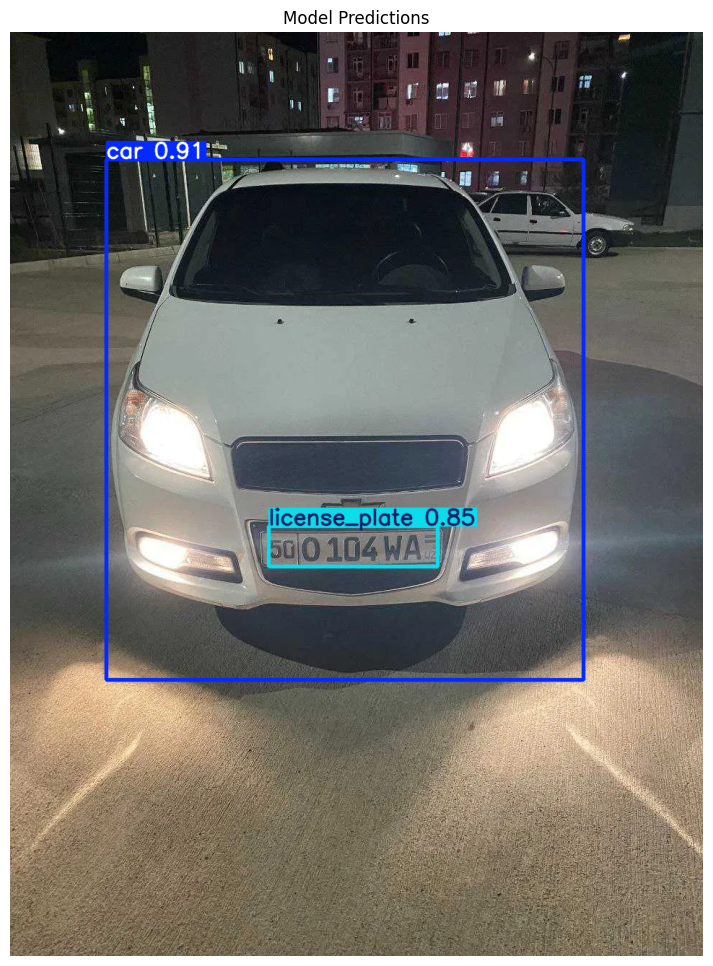

In [13]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

model_path = 'runs/detect/uzbek_plates_yolov8s_v3_final/weights/best.pt'


test_image_path = '/content/test3.webp'


print(f"Loading custom model from: {model_path}")
try:
    model = YOLO(model_path)
    print(" Model loaded successfully!")
except Exception as e:
    print(f" Error loading model: {e}")
    # Stop if the model can't be loaded
    exit()

# --- Runing Inference on a Test Image ---
print(f"\nRunning inference on: {test_image_path}")
try:
    # Using the model to predict objects in the image
    results = model(test_image_path)

    # The 'results' object contains the detections. We can plot them directly.
    # The plot() method returns an image with the boxes drawn on it.
    annotated_image_bgr = results[0].plot()

    # Converting from BGR to RGB for correct color display in Matplotlib
    annotated_image_rgb = cv2.cvtColor(annotated_image_bgr, cv2.COLOR_BGR2RGB)

    # Displaying the image with predictions
    plt.figure(figsize=(12, 12))
    plt.imshow(annotated_image_rgb)
    plt.title("Model Predictions")
    plt.axis('off')
    plt.show()

except FileNotFoundError:
    print(f" Error: The test image was not found at '{test_image_path}'.")
    print("Please upload a test image and/or update the 'test_image_path' variable.")
except Exception as e:
    print(f" An error occurred during inference: {e}")

# Step 6: Cropping Plates for OCR


0: 640x480 1 car, 1 license_plate, 13.6ms
Speed: 2.5ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)
Found 2 total objects.

Found a license plate!
Displaying cropped license plate...


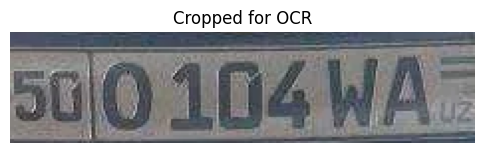

In [21]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Loading model
model = YOLO('runs/detect/uzbek_plates_yolov8s_v3_final/weights/best.pt')

# Pathing to an image
image_path = '/content/test3.webp'

# Loading the original image
original_image = cv2.imread(image_path)

# Running detection
results = model(original_image)

print(f"Found {len(results[0].boxes)} total objects.")

# Looping through each detected object
for box in results[0].boxes:
    # Checking if the detected object is a 'license_plate'
    class_id = int(box.cls[0])
    if model.names[class_id] == 'license_plate':
        print("\nFound a license plate!")

        # Getting the coordinates of the bounding box
        coords = box.xyxy[0] # Format: (x1, y1, x2, y2)
        x1, y1, x2, y2 = map(int, coords)

        # Cropping the license plate from the original image
        cropped_plate = original_image[y1:y2, x1:x2]

        print("Displaying cropped license plate...")

        # Converting BGR to RGB for displaying
        cropped_plate_rgb = cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(6, 3))
        plt.imshow(cropped_plate_rgb)
        plt.title("Cropped for OCR")
        plt.axis('off')
        plt.show()
